In [1]:
%matplotlib inline
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import binom
import pandas as pd
import numpy as np

from minavrfpy import lib

## single epoch

In [3]:
epoch = 25
bp_key = "B62qrQiw9JhUumq457sMxicgQ94Z1WD9JChzJu19kBE8Szb5T8tcUAC"

results = lib.get_epoch_df(epoch, block_producer_key=bp_key)

df = results['df']
stakes_df = results['stakes_df']

## outcome per epoch

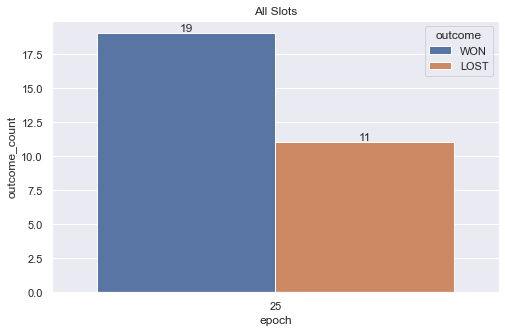

In [4]:
sns.set(rc={"figure.figsize": (8, 5)})


counts_df = (
    df.groupby("epoch")
    .outcome.value_counts()
    .to_frame()
    .rename(columns={"outcome": "outcome_count"})
    .reset_index()
)

ax = sns.barplot(x="epoch", y="outcome_count", data=counts_df, hue="outcome")
ax.set_title("All Slots")
for container in ax.containers:
    ax.bar_label(container)

## outcome grouped by super_charged

In [5]:
df.groupby(["epoch", "super_charged"]).outcome.value_counts()

epoch  super_charged  outcome
25     False          WON         5
                      LOST        2
       True           WON        14
                      LOST        9
Name: outcome, dtype: int64

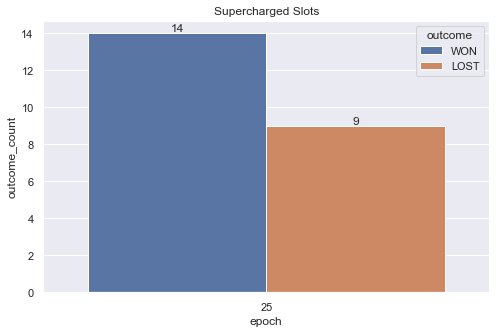

In [6]:
sns.set(rc={"figure.figsize": (8, 5)})


counts_df = (
    df[df.super_charged == True].groupby("epoch")
    .outcome.value_counts()
    .to_frame()
    .rename(columns={"outcome": "outcome_count"})
    .reset_index()
)

ax = sns.barplot(x="epoch", y="outcome_count", data=counts_df, hue="outcome")
ax.set_title("Supercharged Slots")
for container in ax.containers:
    ax.bar_label(container)

In [7]:
df[df.outcome == "MISSED_NOT_PRODUCED"]

,epoch,slot,global_slot,block,winner_exists,saw_my_producer,bp_won,block_time,received_time,winner_pk,super_charged,block_height_equal,too_late,min_bt,min_bt_minutes,outcome,next_block_in


In [8]:
df[df.outcome == "MISSED_HEIGHT_DIFF"]

,epoch,slot,global_slot,block,winner_exists,saw_my_producer,bp_won,block_time,received_time,winner_pk,super_charged,block_height_equal,too_late,min_bt,min_bt_minutes,outcome,next_block_in


In [9]:
df[df.outcome == "MISSED_TOO_LATE"]

,epoch,slot,global_slot,block,winner_exists,saw_my_producer,bp_won,block_time,received_time,winner_pk,super_charged,block_height_equal,too_late,min_bt,min_bt_minutes,outcome,next_block_in


## slot luck
try to visualize "slot luck"


epoch 25 - expected 42 slots - got 30... 


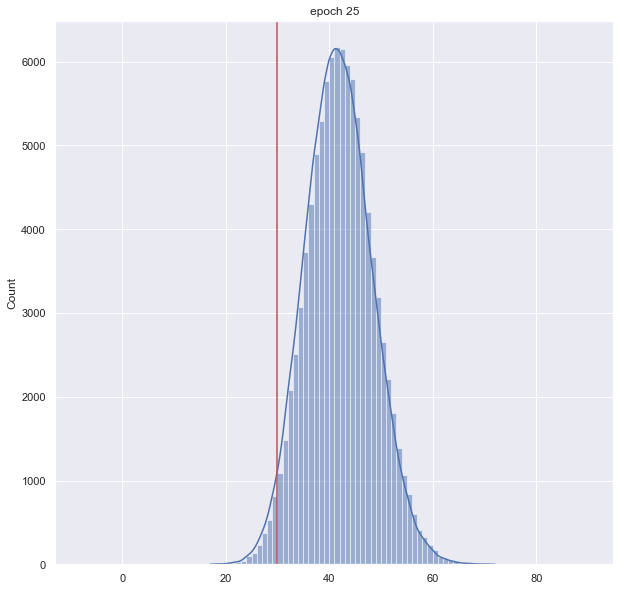

<Figure size 576x360 with 0 Axes>

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

SLOTS_PER_EPOCH = 7140

def get_slot_win_perc(stake, total_currency):
    return (1 - ((1 / 4) ** (stake / total_currency)))


epoch_data = []

total_currency = results['epoch_data']['total_currency']
total_staking_balance = results['stakes_df'].balance.sum()

slot_win_pct = get_slot_win_perc(
    total_staking_balance, total_currency
)    
expected_blocks_value = slot_win_pct * SLOTS_PER_EPOCH 

won_blocks = df[(df.epoch == epoch) & (df.outcome == 'WON')].block.count()
slots_won = df[(df.epoch == epoch)].slot.nunique()

data = binom.rvs(n=SLOTS_PER_EPOCH, p=slot_win_pct, size=100000)

k = np.arange(int(expected_blocks_value - 50), int(expected_blocks_value) + 50, 1)

plt.figure(epoch)

sns.histplot(data, kde=True, bins=k, ax=ax)
ax.axvline(slots_won, 0, 1, color="r")
ax.set_title(f"epoch {epoch}")

epoch_data.append({
    'epoch': epoch,
    'expected_slots': expected_blocks_value,
    'expected_slots_binom': binom(SLOTS_PER_EPOCH, slot_win_pct).expect(),
    'slot_win_pct': slot_win_pct,
    'won_slots': slots_won,
    'won_blocks': won_blocks,
    'orphan_rate': 1 - (won_blocks/slots_won)
})

print(f"epoch {epoch} - expected {round(expected_blocks_value)} slots - got {slots_won}... ")


plt.show()

In [11]:
epoch_slots_df = pd.DataFrame(epoch_data)

epoch_slots_df["cdf"] = epoch_slots_df.apply(
    lambda row: binom.cdf(row["won_slots"], SLOTS_PER_EPOCH, row["slot_win_pct"]),
    axis=1,
)
epoch_slots_df

,epoch,expected_slots,expected_slots_binom,slot_win_pct,won_slots,won_blocks,orphan_rate,cdf
0,25,41.873444,41.873444,0.005865,30,19,0.366667,0.033942
